# 1.3 mln t-SNE

http://cf.10xgenomics.com/supp/cell-exp/megacell_tutorial.html

In [1]:
# Prepare

%matplotlib notebook

import numpy as np
import pylab as plt
import seaborn as sns; sns.set()
import pandas as pd
import matplotlib
import pickle
import scipy
import time

# this makes all figure backgrounds white, also when exporting as png
matplotlib.rcParams.update({'nbagg.transparent': False, 'figure.facecolor': 'white'})

In [2]:
clustersScanpy = pd.read_csv('../data/10x-1mln/louvain.csv').values[:,1]
clustersScanpy = np.concatenate(([0], clustersScanpy)).astype(int)

# Scanpy colors (originally from http://godsnotwheregodsnot.blogspot.com/2013/11/kmeans-color-quantization-seeding.html)
clusterCols = ["#FFFF00", "#1CE6FF", "#FF34FF", "#FF4A46", "#008941", "#006FA6", "#A30059",
        "#FFDBE5", "#7A4900", "#0000A6", "#63FFAC", "#B79762", "#004D43", "#8FB0FF", "#997D87",
        "#5A0007", "#809693", "#FEFFE6", "#1B4400", "#4FC601", "#3B5DFF", "#4A3B53", "#FF2F80",
        "#61615A", "#BA0900", "#6B7900", "#00C2A0", "#FFAA92", "#FF90C9", "#B903AA", "#D16100",
        "#DDEFFF", "#000035", "#7B4F4B", "#A1C299", "#300018", "#0AA6D8", "#013349", "#00846F",
        "#372101", "#FFB500", "#C2FFED", "#A079BF", "#CC0744", "#C0B9B2", "#C2FF99", "#001E09",
        "#00489C", "#6F0062", "#0CBD66", "#EEC3FF", "#456D75", "#B77B68", "#7A87A1", "#788D66",
        "#885578", "#FAD09F", "#FF8A9A", "#D157A0", "#BEC459", "#456648", "#0086ED", "#886F4C",
        "#34362D", "#B4A8BD", "#00A6AA", "#452C2C", "#636375", "#A3C8C9", "#FF913F", "#938A81",
        "#575329", "#00FECF", "#B05B6F", "#8CD0FF", "#3B9700", "#04F757", "#C8A1A1", "#1E6E00",
        "#7900D7", "#A77500", "#6367A9", "#A05837", "#6B002C", "#772600", "#D790FF", "#9B9700",
        "#549E79", "#FFF69F", "#201625", "#72418F", "#BC23FF", "#99ADC0", "#3A2465", "#922329",
        "#5B4534", "#FDE8DC", "#404E55", "#0089A3", "#CB7E98", "#A4E804", "#324E72", "#6A3A4C",
        "#83AB58", "#001C1E", "#D1F7CE", "#004B28", "#C8D0F6", "#A3A489", "#806C66", "#222800",
        "#BF5650", "#E83000", "#66796D", "#DA007C", "#FF1A59", "#8ADBB4", "#1E0200", "#5B4E51",
        "#C895C5", "#320033", "#FF6832", "#66E1D3", "#CFCDAC", "#D0AC94", "#7ED379", "#012C58"][:60]
clusterCols = np.array(clusterCols)

# Load the results processed on the server

X = pickle.load(open('million-pickles/pca-scanpy.pickle', 'rb')).astype(float)

Z25k, position_id = pickle.load(open("million-pickles/downsampling.pickle", "rb"))
np.random.seed(42)
ind25k  = np.random.choice(X.shape[0], 25000, replace=False)

Zs = pickle.load(open("million-pickles/tsne-results.pickle", "rb"))

Z25k = -Z25k[:,::-1]
Zs[0] = -Zs[0][:,::-1]
Zs[1] = -Zs[1][:,::-1]
Zs[2] = -Zs[2][:,::-1]
Zs[4] = -Zs[4][:,::-1]

Z_umap = pickle.load(open("million-pickles/umap-results.pickle", "rb"))

[markergenes, markerexp] = pickle.load(open("million-pickles/markers.pickle", "rb"))

print(np.sort(markergenes))
print(len(markergenes))

['Acsbg1' 'Akap7' 'Aldoc' 'Aqp4' 'Bgn' 'Ctss' 'Eomes' 'Flt1' 'Foxp2' 'Gad1'
 'Gad2' 'Gja1' 'Gjb6' 'Hes1' 'Htr3a' 'Itgam' 'Itgam' 'Lcat' 'Meg3' 'Mog'
 'Myl9' 'Neurod6' 'Nrn1' 'Nrp1' 'Olig1' 'Pax6' 'Pdgfra' 'Pvalb' 'Reln'
 'S1pr1' 'Slc17a6' 'Slc17a7' 'Slc1a3' 'Slc32a1' 'Snap25' 'Sox2' 'Sst'
 'Stmn2' 'Tac1' 'Tac2' 'Tbr1' 'Top2a' 'Tubb3' 'Vip' 'Xdh']
45


In [4]:
def mlnplot(Z, ind=None, size=6, alpha=.1, labels=True, showmeans=True, rasterize=True, omit_means=None):
    if ind is None:
        ind = np.arange(Z.shape[0])

    if size is not None:
        plt.figure(figsize=(size,size))
    
    plt.scatter(Z[:,0], Z[:,1], s=1, c=clusterCols[clustersScanpy[ind]], alpha=alpha, rasterized=rasterize)
    
    K = np.max(clustersScanpy)+1
    Zmeans = np.zeros((K, 2))
    for c in range(K):
        if np.any(np.isnan(Z[clustersScanpy[ind]==c,0])):
            Zmeans[c,:] = np.nan
        else:
            Zmeans[c,:] = np.median(Z[clustersScanpy[ind]==c,:2], axis=0)
            
    if omit_means is None:
        means_to_show = np.arange(K)
    else:
        means_to_show = np.array([c for c in np.arange(K) if c not in omit_means])
            
    if showmeans:
        plt.scatter(Zmeans[means_to_show,0], Zmeans[means_to_show,1], 
                    color=clusterCols[means_to_show],
                    s=150, edgecolor='k', linewidth=.7);
    
    if showmeans and labels:
        for c in means_to_show:
            if c in [12,21,37,32,35,9,15,18]:
                col = 'w'
            else:
                col = 'k'
            plt.text(Zmeans[c,0], Zmeans[c,1],
                     str(c), fontsize=7, color=col,
                     horizontalalignment='center', verticalalignment='center')
    
    plt.gca().get_xaxis().set_ticklabels([])
    plt.gca().get_yaxis().set_ticklabels([])
    if size is not None:
        plt.tight_layout()

<IPython.core.display.Javascript object>


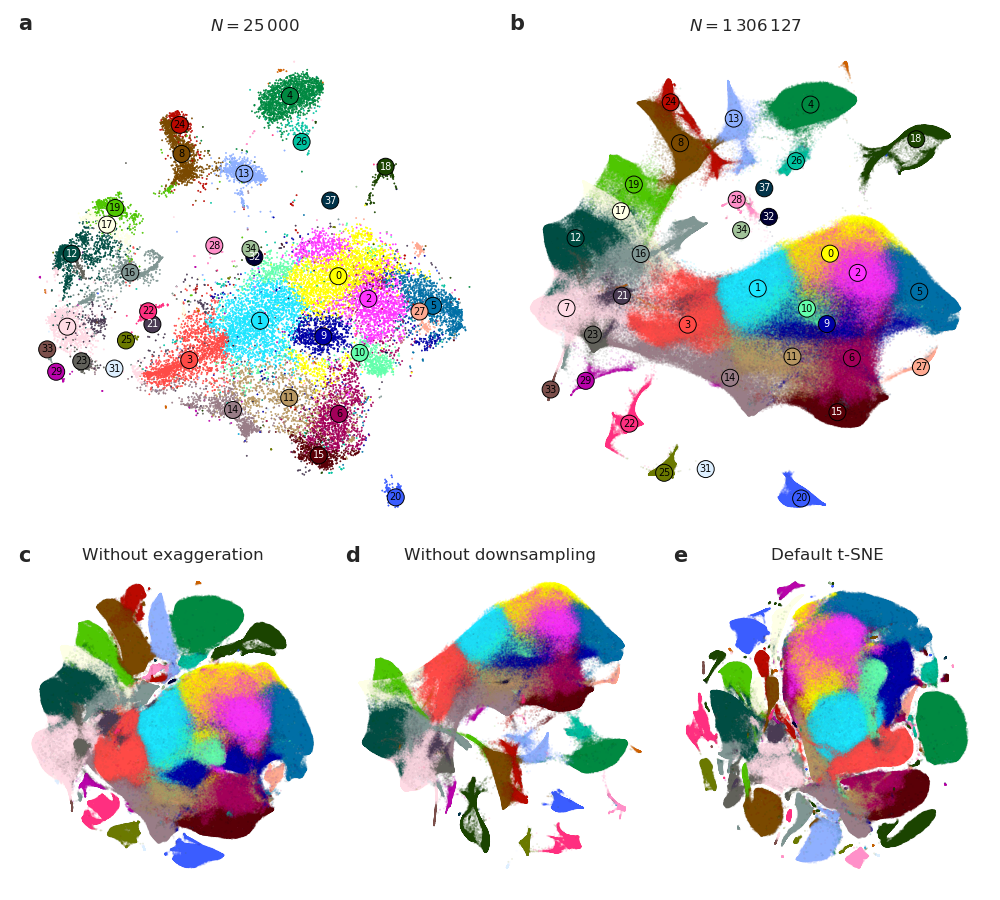

In [6]:
sns.set_style('white')

plt.figure(figsize=(10,9))
ax1 = plt.subplot2grid((5, 6), (0, 0), colspan=3, rowspan=3)
mlnplot(Z25k, ind=ind25k, alpha=1, size=None, omit_means=[30, 35, 36, 38])
plt.title(r'$N=25\,000$')
plt.tight_layout()

ax2 = plt.subplot2grid((5, 6), (0, 3), colspan=3, rowspan=3)
mlnplot(Zs[0], size=None, omit_means=[30, 35, 36, 38])
plt.title(r'$N=1\,306\,127$')

ax3 = plt.subplot2grid((5, 6), (3, 0), rowspan=2, colspan=2)
mlnplot(Zs[1], size=None, labels=False, showmeans=False)
plt.title('Without exaggeration')

ax4 = plt.subplot2grid((5, 6), (3, 2), rowspan=2, colspan=2)
mlnplot(Zs[2], size=None, labels=False, showmeans=False)
plt.title('Without downsampling')

ax5 = plt.subplot2grid((5, 6), (3, 4), rowspan=2, colspan=2)
mlnplot(Zs[3], size=None, labels=False, showmeans=False)
plt.title('Default t-SNE')

sns.despine(left=True, bottom=True)
plt.text(0, 1.02, 'a', transform = plt.gcf().get_axes()[0].transAxes, fontsize=15, fontweight='bold')
plt.text(0, 1.02, 'b', transform = plt.gcf().get_axes()[1].transAxes, fontsize=15, fontweight='bold')
plt.text(0, 1.02, 'c', transform = plt.gcf().get_axes()[2].transAxes, fontsize=15, fontweight='bold')
plt.text(0, 1.02, 'd', transform = plt.gcf().get_axes()[3].transAxes, fontsize=15, fontweight='bold')
plt.text(0, 1.02, 'e', transform = plt.gcf().get_axes()[4].transAxes, fontsize=15, fontweight='bold')
plt.tight_layout()
plt.savefig('figures/mln-tsne.png')
plt.savefig('figures/mln-tsne.pdf', dpi=300)

sns.set()

<IPython.core.display.Javascript object>


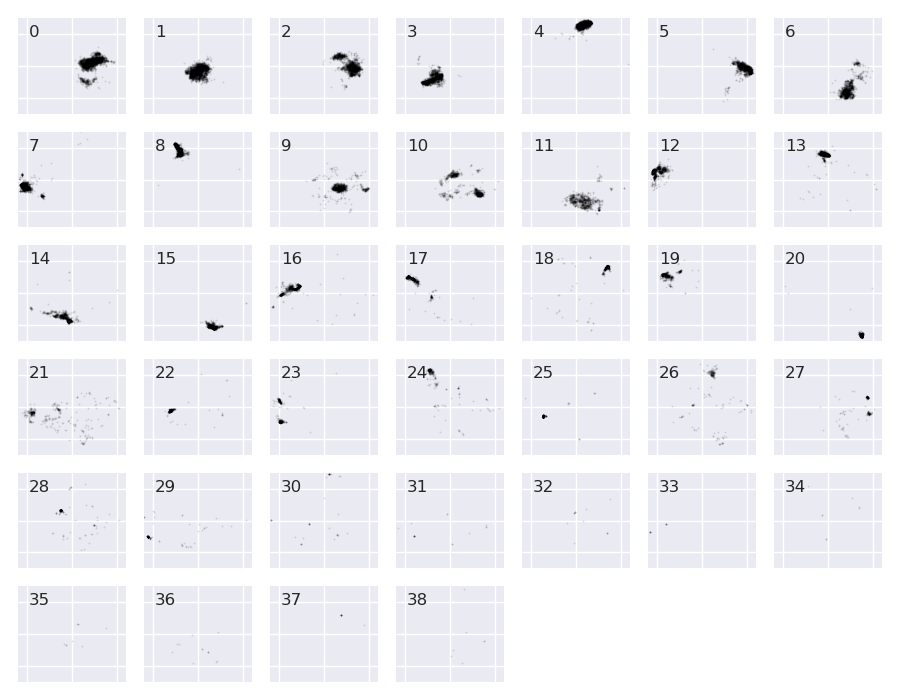

<IPython.core.display.Javascript object>


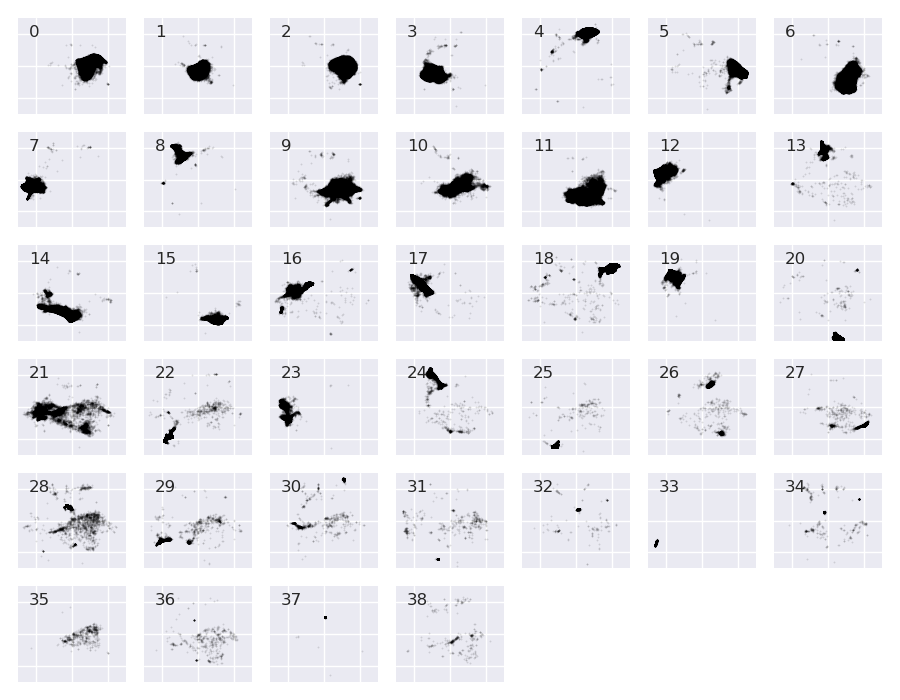

In [14]:
# Which cluster means to hide from the main figure (because they are not "clustered")

plt.figure(figsize=(9,7))
for i in range(39):
    plt.subplot(6,7,i+1)
    plt.scatter(Z25k[clustersScanpy[ind25k]==i,0], Z25k[clustersScanpy[ind25k]==i,1], color='k',s=1,alpha=.1)
    plt.gca().get_xaxis().set_ticklabels([])
    plt.gca().get_yaxis().set_ticklabels([])
    plt.xlim([-30,30])
    plt.ylim([-30,30])
    plt.text(.1, .8, str(i), transform = plt.gca().transAxes)
plt.tight_layout()

plt.figure(figsize=(9,7))
for i in range(39):
    plt.subplot(6,7,i+1)
    plt.scatter(Zs[0][clustersScanpy==i,0], Zs[0][clustersScanpy==i,1], color='k', s=1, alpha=.1)
    plt.gca().get_xaxis().set_ticklabels([])
    plt.gca().get_yaxis().set_ticklabels([])
    plt.xlim([-15,15])
    plt.ylim([-15,15])
    plt.text(.1, .8, str(i), transform = plt.gca().transAxes)
plt.tight_layout()

# [30, 34, 35, 36, 38]

<IPython.core.display.Javascript object>


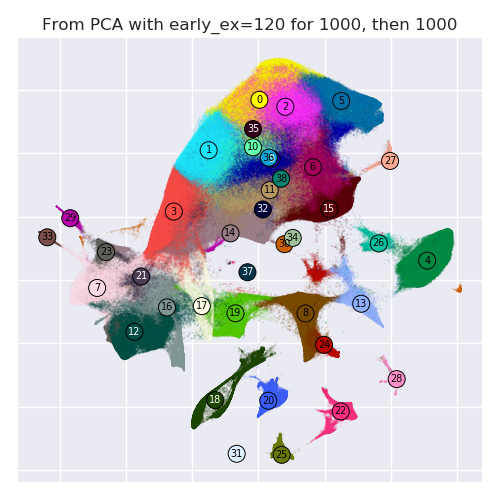

In [15]:
# Aggressive early exaggeration

mlnplot(Zs[4], size=5)
plt.title('From PCA with early_ex=120 for 1000, then 1000')
plt.tight_layout()

In [3]:
# MARKER GENES

# From Tasic 2016: Aqp4 (astrocytes); Pdgfra (oligodendrocyte precursor cells, OPCs); Mog (oligodendrocytes); 
# Itgam (microglia); Flt1 (endothelial cells); and Bgn (smooth muscle cells, SMC)

# Non-neuronal cells. We identify astrocytes based on expression of previously reported 
# markers Aqp4, F3, and Gfap12. Our Oligo-96*Rik type corresponds to previously described 
# newly generated oligodendrocytes based on the unique expression of Enpp6 and 9630013A20Rik 
# (abbreviated as 96*Rik), while our Oligo-Opalin type corresponds to myelinating oligodendrocytes13.
# Oligo precursor cells (OPC) express Pdgfra and Cspg4 as previously reported12,13. Accordingly,
# microglial cells express Itgam, Cx3cr1 and C1qb13. We identify endothelial cells based on 
# expression of Flt1 (ref. 13), and smooth muscle cells (SMC) based on the expression of Bgn

# From Allen Data RNAseq whitepaper: 'Olig1', 'Gja1', 'Xdh', 'Ctss', 'Myl9'

# From https://www.biorxiv.org/content/biorxiv/early/2017/10/03/197244.full.pdf
# Tubb23 - neurons, Slc1a3 - radial glia, Top2a - dividing cells, Stmn2 - neurons
# Meg3 - interneurons and CR, Nrp1 - glutamat, Gad2 - interneurons,
# Tac2 - neuroblasts, Reln - CR, Pax6 - glia, Tbr2 - neural progenitors,
# Tbr1 - post-mitotic neurons
#
# Englung: Pax6 (radial glia) -> Eomes (aka Tbr2) (committed progenitors) -> Tbr1 (pyramidal neurons)

# Add from http://www.sequmed.com/Private/Files/20170726/6363668905396462451645665.pdf
# Stmn2 - pan neuronal
# Tbr1 - excitatory
# Gad1 - inhibitory
# Hes1 - glia
# Aldoc - astrocyte - this is wrong, Aldoc is a strong radial glia marker
# Oligo1 - oligodendrocytes

<IPython.core.display.Javascript object>


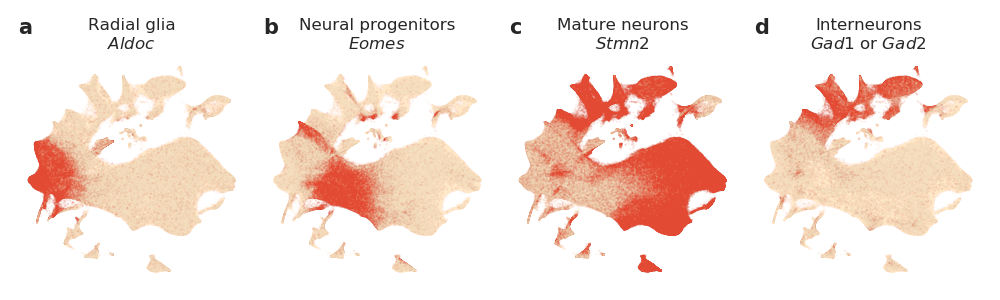

In [16]:
# Slc1a3 similar to Aldoc but goes more into Eomes
# Tubb3 siimlar to Stmn2 but also goes more into Eomes
markers = [['Aldoc'], ['Eomes'], ['Stmn2'], ['Gad1', 'Gad2']]
titles = ['Radial glia\n' + r'$\mathit{Aldoc}$',
          'Neural progenitors\n' + r'$\mathit{Eomes}$',
          'Mature neurons\n' + r'$\mathit{Stmn2}$',
          'Interneurons\n' + r'$\mathit{Gad1}$ or $\mathit{Gad2}$']

sns.set_style('white')
plt.figure(figsize=(10,3))

for i,genes in enumerate(markers):
    plt.subplot(1, len(markers), i+1)
    detected = np.sum(markerexp[:, np.isin(markergenes, genes)], axis=1) > 0
    colors = ['#e34a33' if c else '#fee8c8' for c in detected]
    plt.scatter(Zs[0][:,0], Zs[0][:,1], s=1, c=colors, alpha=.1, rasterized=True)
    plt.title(titles[i])
    plt.gca().get_xaxis().set_ticklabels([])
    plt.gca().get_yaxis().set_ticklabels([])

sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.text(0, 1.1, 'a', transform = plt.gcf().get_axes()[0].transAxes, fontsize=15, fontweight='bold')
plt.text(0, 1.1, 'b', transform = plt.gcf().get_axes()[1].transAxes, fontsize=15, fontweight='bold')
plt.text(0, 1.1, 'c', transform = plt.gcf().get_axes()[2].transAxes, fontsize=15, fontweight='bold')
plt.text(0, 1.1, 'd', transform = plt.gcf().get_axes()[3].transAxes, fontsize=15, fontweight='bold')

plt.savefig('figures/mln-markers.png')
plt.savefig('figures/mln-markers.pdf', dpi=300)

sns.set()

<IPython.core.display.Javascript object>


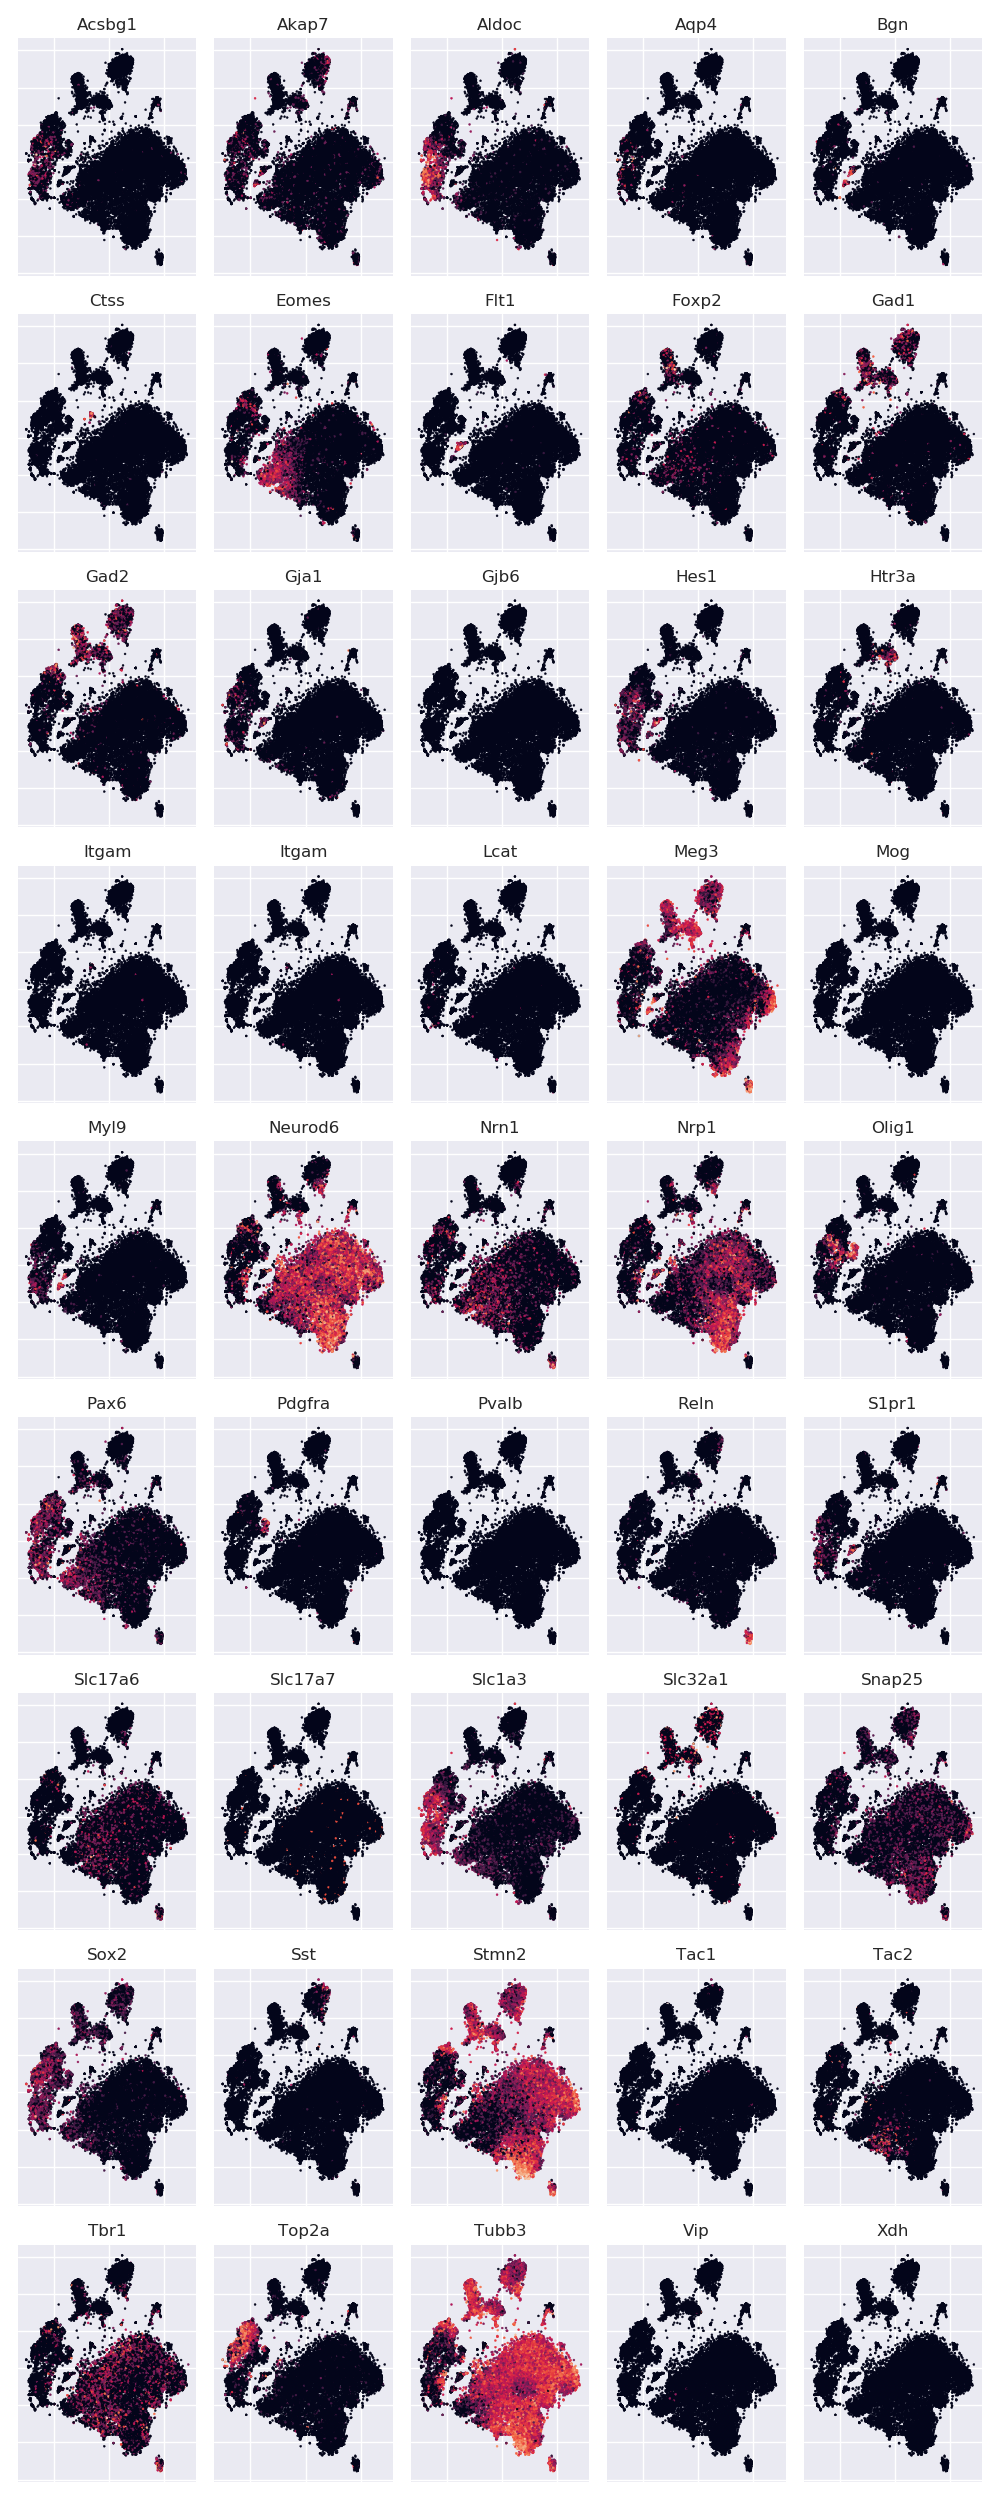

In [161]:
plt.figure(figsize=(10,25))

for i,gene in enumerate(np.sort(markergenes)):
    plt.subplot(9,5,i+1)
    plt.scatter(Z25k[:,0], Z25k[:,1], s=2, c=np.log2(1+np.sum(markerexp[:,markergenes==gene][ind25k,:],axis=1)))
    plt.title(gene)
    plt.gca().get_xaxis().set_ticklabels([])
    plt.gca().get_yaxis().set_ticklabels([])

plt.tight_layout()

## UMAP

<IPython.core.display.Javascript object>


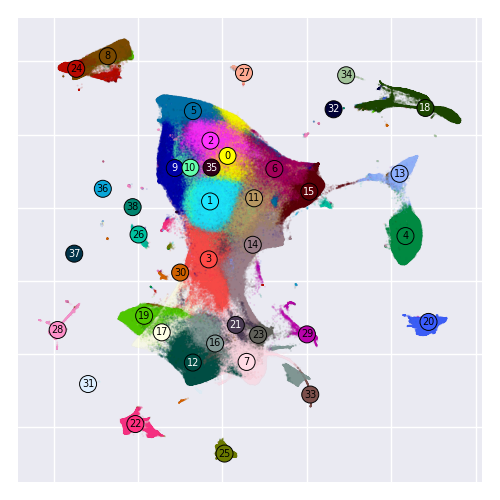

In [6]:
mlnplot(Z_umap, size=5)

<IPython.core.display.Javascript object>


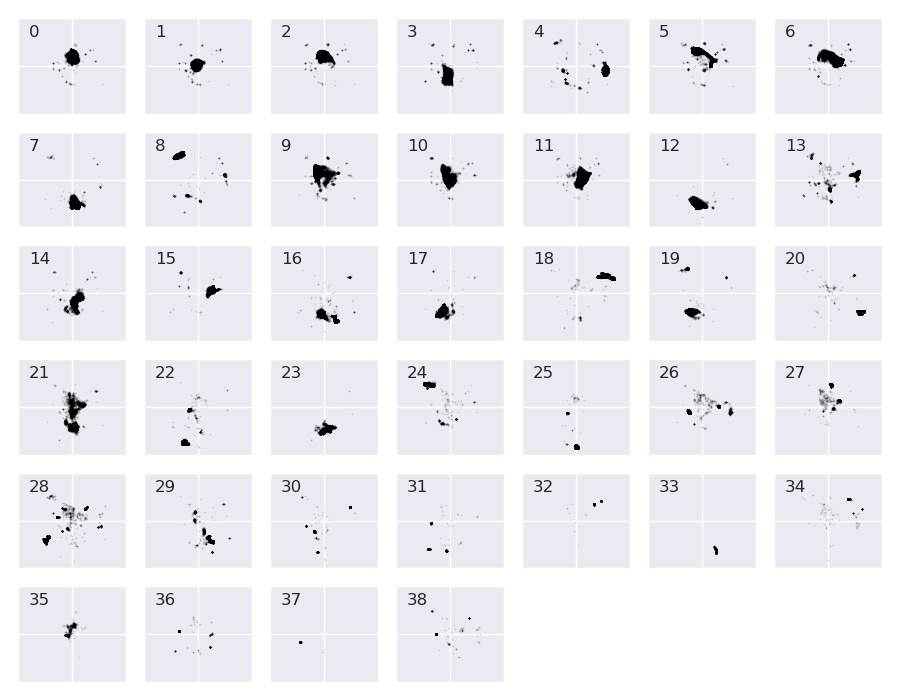

In [10]:
plt.figure(figsize=(9,7))
for i in range(39):
    plt.subplot(6,7,i+1)
    plt.scatter(Z_umap[clustersScanpy==i,0], Z_umap[clustersScanpy==i,1], color='k',s=1,alpha=.1)
    plt.gca().get_xaxis().set_ticklabels([])
    plt.gca().get_yaxis().set_ticklabels([])
    plt.xlim([-20,20])
    plt.ylim([-20,20])
    plt.text(.1, .8, str(i), transform = plt.gca().transAxes)
plt.tight_layout()